# A predictive maintenance project in the solar industry

<ul>
    <li>1 - Context of problematic</li>
    <li>2 - Presentation of data</li>
    <li>3 - Study of hypothesis</li>
    <li>4 - Modeling and learning</li>
    <li>5 - Results and operation</li>
</ul>    

<img src="./Pictures/Fotolia_62738424_XS.jpg" />

## 1 - Context of problematic

#### In the solar industry to make a photovoltaic panel, one of the crucial steps is the cutting of silicon ingots into wafers.

<img src="./Pictures/Ingot.PNG" />

#### For this, diamond wire saws are used. These equipment are very efficient but also subject to drift manufacturing. Quality monitoring is therefore imperative.
<img src="./Pictures/Scie_Diamant.jpg" />
#### In our context, important and regular drifts were observed. This is why a predictive maintenance prediction project was set up to reduce the impact of these production anomalies.

<img src="./Pictures/Distribution Gausienne.png" />
#### The aim was to predict when a drift would occur in order to realize an action of maintenance to prevent the anomaly (for example change the wire of the saw or recalibrate settings...).

## 2 - Presentation of data

#### For this project, we had a datadet with a dozen of variables. Each hour for each day (the factory was working on unceasing full time shift - 24 hours a day), when a cut is performed on a silicium ingot, a log file is produced with many useful informations.

#### Here are the most useful variables which be used for this project :
<img src="./Pictures/Variables.png" />

In [40]:
import pandas as pd
import numpy as np

path = './/Data'
fileName = 'Data_Maintenance.csv'

filePath = '//'.join([path,fileName])

data_maintenance = pd.read_csv(filePath,delimiter=';')


In [41]:
data_maintenance.head(5)

,Date,Time,DateTime,TTV,Thickness,SawGroove,SawEdge,SawStep,LastEmptying,OutSixSigma,WafersProduction,SiliciumType
0,01/01/2017,00:00,01/01/2017 00:00,30,250,120,1,0,01/01/2017,0,1000,Mono
1,01/01/2017,01:00,01/01/2017 01:00,30,251,121,0,0,01/01/2017,0,3000,Mono
2,01/01/2017,02:00,01/01/2017 02:00,30,251,120,0,0,01/01/2017,0,5000,Mono
3,01/01/2017,03:00,01/01/2017 03:00,31,251,119,2,0,01/01/2017,0,6000,Mono
4,01/01/2017,04:00,01/01/2017 04:00,32,251,124,1,0,01/01/2017,0,7000,Mono


#### Let's take a look at the data :

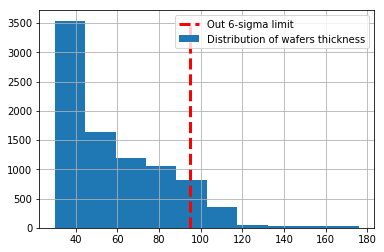

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

data_maintenance.TTV.hist(label="Distribution of wafers thickness")
plt.plot([95, 95], [0, 3500],
         color='red',
         linestyle='--',
         linewidth=3,
         label="Out 6-sigma limit")

plt.legend(loc='upper right');
plt.show()


#### As we can see, mostly 15% of the production is out 6-sigma limit. It's a lot and it's a quite waste of ressources since the wafers which doesn't respond to quality criteria are thrown away.

#### That's why this project of predictive maintenance has for first goal to prevent this drift of non quality production, because the cost of these anomalies are pretty heavy for the firm.

## 3 - Study of hypothesis

#### At first, before beginning the step of modeling, we have to check the following hypothesis :
<ul>
    <li>A - Hypothesis of normality of data</li>
    <li>B - Hypothesis of stationnary time serie</li>
    <li>C - Hypothesis of event without memory (Markov process)</li>
</ul>


### A - Hypothesis of normality of data

#### The purpose of the verification of this hypothesis is to know if parametric methods can be used for our learning model.

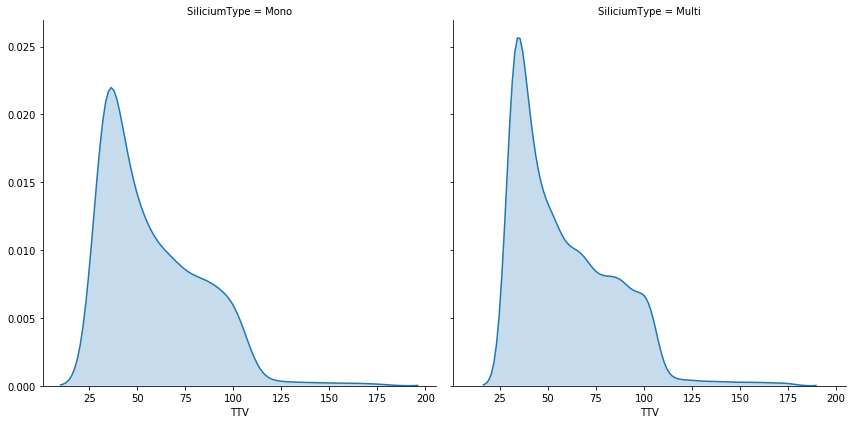

In [14]:
g = sns.FacetGrid(data_maintenance, 
                  col="SiliciumType", 
                  size=6)

g.map(sns.kdeplot,
      "TTV",
      shade=True)

plt.xlabel('TTV')
plt.show()


#### A first visual look would suggest that the parameter observed doesn't follow a gaussian distribution (low Skewness and non symetric Kurtosis).

#### We could check also with a QQ plot test (using percentile cumul) :

C:\Users\monne\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


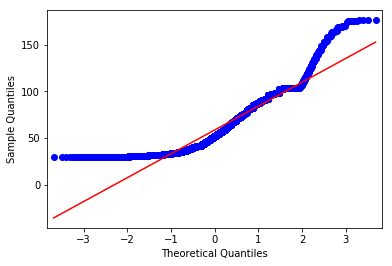

In [15]:
import scipy
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import anderson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARIMA

qqplot(data_maintenance.TTV, line='s')
plt.show()


#### It seems that the distribution is not a gaussian one...
#### To be sure, we could compute a statiscal test and we will use the following ones :
<ul>
<li>Shapiro Test </li>
<li>D'Agostino Test</li>
<li>Anderson Test</li>
</ul>


In [17]:
stats,p_value = shapiro(data_maintenance.TTV)
print('Stats = {} - p-value = {}'.format(stats,p_value))


Stats = 0.8932368159294128 - p-value = 0.0


C:\Users\monne\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
# D'Agostino and Pearson's Test
print(scipy.stats.normaltest(data_maintenance.TTV))

NormaltestResult(statistic=1268.5132451261297, pvalue=3.514379931470798e-276)


In [28]:
# Anderson's Test
result = anderson(data_maintenance.TTV)
print('Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
	
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('Critical value of {}%  : {} --> data doesn\'t look normal (reject H0)'.format(round(sl,0), cv))


Statistic: 259.087
Critical value of 15.0%  : 0.576 --> data doesn't look normal (reject H0)
Critical value of 10.0%  : 0.656 --> data doesn't look normal (reject H0)
Critical value of 5.0%  : 0.787 --> data doesn't look normal (reject H0)
Critical value of 2.0%  : 0.918 --> data doesn't look normal (reject H0)
Critical value of 1.0%  : 1.092 --> data doesn't look normal (reject H0)


## B - Hypothesis of stationnary time serie

#### A first look on the distribution of one of the parameter (the BOW measure which is globally the same as the TTV criteria) would indicate that fluctuations are following a time serie, as we could read on the below picture :
<img src="./Pictures/Distribution Chronologique.png" />

#### Let's check this assumption :
<ul>
    <li>Transform the data</li>
    <li>Test of Ad Fuller</li>
    <li>ARIMA performing</li>
</ul>    

### Transform the data :

#### At first, we have to group the data on the variable Date in order to be able to compute the analysis on a daily basis.

In [30]:
data_maintenance['year'] = data_maintenance['Date'].apply(lambda x:x[len(x)-4:])
data_maintenance['month'] = data_maintenance['Date'].apply(lambda x:x[len(x)-7:len(x)-5])
data_maintenance['day'] = data_maintenance['Date'].apply(lambda x:x[:2])
     
data_maintenance['date_py'] = pd.to_datetime(data_maintenance[['year','month','day']])

grouped = data_maintenance.groupby('date_py')
mean_TTV = grouped['TTV'].agg(np.mean)
print(mean_TTV.head(5))


date_py
2017-01-01    52.333333
2017-01-02    56.291667
2017-01-03    57.291667
2017-01-04    57.333333
2017-01-05    57.333333
Name: TTV, dtype: float64


#### The dataset is now regrouped by the date of the day (we keep the mean of each variable)


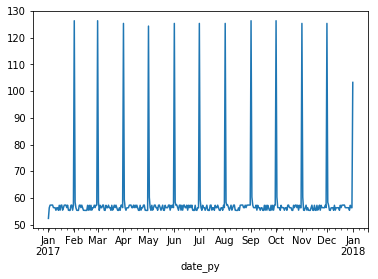

In [32]:
mean_TTV.plot()
plt.show()

#### The graphical visualisation could let think that we are facing a stationnary time series use case...
#### Stationnary, because there is no trend, the variance doesn't grow with the date and there is not sign of covariance with the time axis...

### Augmented Dickey Fuller Test

In [33]:

print('--'*20)
print('Augmented Dickey Fuller Test')

results = adfuller(mean_TTV,
                   autolag='AIC')

test_statistics,p_value = results[0],results[1]

print('valeur du test : {} - Valeur de la p-value : {}'.format(test_statistics,
                                                          p_value))

for key,value in results[4].items():
    print('Critical value à {} % : {}'.format(key,value))
print('--'*20)    
if p_value < 0.05:
    print('Reject H0 : the serie of fluctuations of TTV is stationnary...') 
else:
    print('Fail to reject H0 : the serie of fluctuations of TTV is not stationnary...') 
    

----------------------------------------
Augmented Dickey Fuller Test
valeur du test : -18.501751389268442 - Valeur de la p-value : 2.1201245071674424e-30
Critical value à 1% % : -3.4483935212959844
Critical value à 5% % : -2.8694912343676497
Critical value à 10% % : -2.571005879151811
----------------------------------------
Reject H0 : the serie of fluctuations of TTV is stationnary...


<img src="./Pictures/Tendance Thickness.PNG" />

### Kwiatkowski-Phillips-Schmidt-Shin Test

In [34]:
print('--'*20)
print('Kwiatkowski-Phillips-Schmidt-Shin Test')    


results = kpss(mean_TTV,
                   regression='c')

test_statistics,p_value = results[0],results[1]

print('valeur du test : {} - Valeur de la p-value : {}'.format(test_statistics,
                                                          p_value))

for key,value in results[3].items():
    print('Critical value à {} % : {}'.format(key,value))
print('--'*20)    
if p_value > 0.05:
    print('Fail to reject H0 : the serie of fluctuations of TTV is stationnary...') 
else:
    print('Reject H0 : the serie of fluctuations of TTV is not stationnary...') 

----------------------------------------
Kwiatkowski-Phillips-Schmidt-Shin Test
valeur du test : 0.036624491810607694 - Valeur de la p-value : 0.1
Critical value à 10% % : 0.347
Critical value à 5% % : 0.463
Critical value à 2.5% % : 0.574
Critical value à 1% % : 0.739
----------------------------------------
Fail to reject H0 : the serie of fluctuations of TTV is stationnary...


C:\Users\monne\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### ARIMA performing

Text(0.5,1,'RSS: 53269.1851')

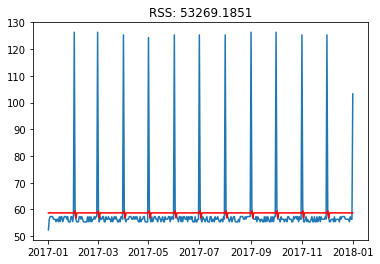

In [35]:
# Forecast with ARIMA model       
model = ARIMA(mean_TTV, order=(2,0, 0))  
results_ARIMA = model.fit()  

plt.plot(mean_TTV)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-mean_TTV)**2))

<ul><li> The ARIMA model seems specifically poor on this case. </li>
    <li> The predictions (in red) is not aligned on the time series.</li>
    <li> And the RSS score is pretty high... but why ???</li>
</ul>    

#### After a lot of research and discussion with the process engineers, it seems that data are not correlated with date or time, but with the number of wafers produced.
#### If nothing is produced while a month, all parameters will remain stable and no drift will be observed. So, our data are not a stationnary time serie use case...
#### It's a bit tricky since results of tests and visual graphics insinuate the opposite, but this is an effect of an hidden correlation between the date and the cumul of number of wafers produced during the interval...

### C - Hypothesis of event without memory (Markov process)

#### If events observed were without memory, no links would be notified with a past parameter. But on the below visualisation, we could see that fluctutations seem correlated with the past cumul of wafers :
<img src="./Pictures/Distribution Wafers.png" />

#### Futhermore, we have observed that drifts are sometimes concomitant with operations of emptying on the saw equipment (oil lubricant). It seems that probability of drift occurence is proportional with the past delay of the last action of emptying performed on the saw equipment :
<img src="./Pictures/Concomittance_Maintenance.png" />
#### So, we can deduct that we are not facing a Markov process use case... 

# 4 - Modeling and learning
<ul>
    <li>A - Design the features</li>
    <li>B - Select the features</li>
    <li>C - Build the model</li>
</ul>    

### A - Design the features

#### in connection with the observations made previously, we will create 4 new features :
<ul>
    <li>A feature to indicate if it is a day when an emptying action is performed</li>
    <li>A feature to calculate the number of wafers produced since the last day of emptying</li>
    <li>A feaure to count the number of days since the last action of emptying</li>
    <li>A dummy feature for coding the type of silicium material (has an impact on the saw wire attrition)</li>
</ul>    

In [43]:
is_emptying =list()
cumul_wafers = list()
day_since_emptying = list()
cumul_ant=0

for index,row in data_maintenance.iterrows():    
    if row['Date'][:2]=='01':
        is_emptying.append(1)
        cumul_wafers.append(0)
        cumul_ant=row['WafersProduction']
        day=int(row['LastEmptying'][:2])
        day_since_emptying.append(0)
        
    else:
        is_emptying.append(0)
        cumul_wafers.append(row['WafersProduction']-cumul_ant)
        day_since_emptying.append(np.abs(int(row['Date'][:2])-day))
        
data_maintenance['day of emptying']  = is_emptying      
data_maintenance['cumul of wafers']  = cumul_wafers  
data_maintenance['day since emptying']  = day_since_emptying  
data_maintenance['Is Mono'] = data_maintenance['SiliciumType'].apply(lambda x: 1 if x=='Mono' else 0)


In [47]:
data_maintenance[['Date','day of emptying','cumul of wafers','LastEmptying','day since emptying','Is Mono']].tail(3)

,Date,day of emptying,cumul of wafers,LastEmptying,day since emptying,Is Mono
8761,01/01/2018,1,0,01/01/2018,0,0
8762,01/01/2018,1,0,01/01/2018,0,0
8763,01/01/2018,1,0,01/01/2018,0,0


### B - Select the features

#### At first, we are checking the correlation between variables since models are sometimes sensitive to it :

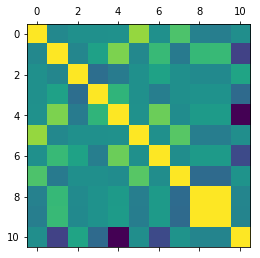

In [48]:
plt.matshow(data_maintenance.corr())

In [52]:
for col in data_maintenance.corr().columns:
    conditions = (data_maintenance.corr()[col]>0.6) & (data_maintenance.corr()[col]<1)
    if len(data_maintenance.corr()[conditions][col])>0:
        columns_correlated = data_maintenance.corr()[conditions][col]
        print('--'*20)
        print(col)
        print('--'*20)
        print(columns_correlated)

----------------------------------------
TTV
----------------------------------------
OutSixSigma    0.682667
Name: TTV, dtype: float64
----------------------------------------
Thickness
----------------------------------------
SawStep    0.604948
Name: Thickness, dtype: float64
----------------------------------------
SawStep
----------------------------------------
Thickness    0.604948
Name: SawStep, dtype: float64
----------------------------------------
OutSixSigma
----------------------------------------
TTV    0.682667
Name: OutSixSigma, dtype: float64
----------------------------------------
cumul of wafers
----------------------------------------
day since emptying    0.999174
Name: cumul of wafers, dtype: float64
----------------------------------------
day since emptying
----------------------------------------
cumul of wafers    0.999174
Name: day since emptying, dtype: float64


#### Then we are trying to detect the variables which explain the most of variability in the dataset with a PCA :

Variances explained by axes : [ 0.31732599  0.21365304  0.13912937  0.12088666]


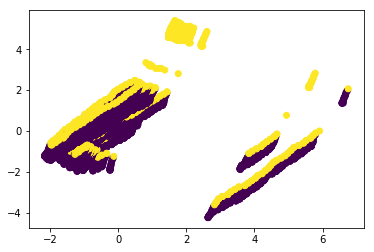

In [53]:
from sklearn.preprocessing import StandardScaler

features = data_maintenance.corr().columns.tolist()
features.remove('OutSixSigma')
target = 'OutSixSigma'

X = data_maintenance.loc[:,features]
y = data_maintenance.loc[:,target]

X = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principal_components,
                           columns = ['PCI' + str(i) for i in range(4)])

plt.scatter(principalDf.iloc[:,0],
            principalDf.iloc[:,1],
            c=y,
            label=y.unique())

print('Variances explained by axes : {}'.format(pca.explained_variance_ratio_))

plt.show()


In [54]:
sortedFeatures_axe1 = [i[0] for i in sorted(zip(features,pca.components_[0]),
                                            key=lambda l:l[1],reverse=True)]

sortedFeatures_axe2 = [i[0] for i in sorted(zip(features,pca.components_[1]),
                                            key=lambda l:l[1],reverse=True)]

sortedFeatures_axe3 = [i[0] for i in sorted(zip(features,pca.components_[2]),
                                            key=lambda l:l[1],reverse=True)]

sortedFeatures_axe4 = [i[0] for i in sorted(zip(features,pca.components_[3]),
                                            key=lambda l:l[1],reverse=True)]
    
print(sortedFeatures_axe1[:1])    
print(sortedFeatures_axe2[:1])  
print(sortedFeatures_axe3[:1])    
print(sortedFeatures_axe4[:1])  

['Is Mono']
['day of emptying']
['SawGroove']
['TTV']


#### Then we have our features which will carry the most of variability for our future learning model.
#### As we can see on the plan projection above, our data are segmented by the type of silicium and the proximity of the day of emptying. 
#### It seems that the day of emptying has an impact on the target feature ("OutOf6Sigma") since points in yellow on the plan, are systemtically above the others (when the axis vertical is carried by the "day of emptying" feature).

<img src="./Pictures/Scatter_TTV.PNG"/>

### C - Build the model

Sensibility of predictions is about : 1.0
Specificity of predictions is about : 1.0
Perimeter of AUC curb : 1.0


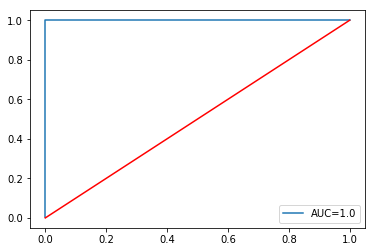

In [55]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(X,
                                                                            y,
                                                                            test_size=0.25,
                                                                            stratify=y)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,roc_curve

model_regression = LogisticRegression()
model_regression.fit(train_features,train_target)
predictions = model_regression.predict(test_features)
probalities = model_regression.predict_proba(test_features)

accuracy = predictions == test_target

true_positives = (predictions==1) & (test_target==1)
false_positives = (predictions==1) & (test_target==0)
true_negatives = (predictions==0) & (test_target==0)
false_negatives = (predictions==0) & (test_target==1)

sensitivity = np.sum(true_positives) / (np.sum(true_positives)+np.sum(false_negatives))

specificity = np.sum(true_negatives) / (np.sum(true_negatives) + np.sum(false_positives))

print('Sensibility of predictions is about : {}'.format(sensitivity))
print('Specificity of predictions is about : {}'.format(specificity))

fpr, tpr, thresholds = roc_curve(test_target, probalities[:,1], pos_label=1)
auc = auc(fpr,tpr)

print('Perimeter of AUC curb : {}'.format(auc))

plt.plot(fpr,tpr,label='AUC={}'.format(auc))
plt.plot([0,1],[0,1],color='red')
plt.legend(loc='lower right')
plt.show()


#### The score of accuracy seems perfect... too perfect. When performing this logistic regression, we made a rookie mistake. We keep features which contain information on the future... the measure of thickness or TTV are not known when the cut is peformed... these values are measured a fews hours later by a specific equipment. It a bias... 
#### When the predicition will be performed, no information about thickness of the wafer will be available.That's why we have toremove these features to build our model :

Sensibility of predictions is about : 0.20491803278688525
Specificity of predictions is about : 1.0
Perimeter of AUC curb : 0.6286194818425994


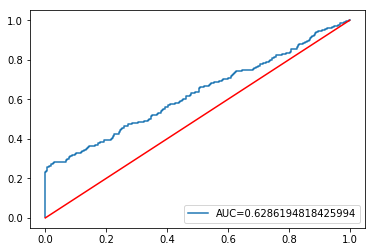

In [59]:

X_reduced = ['cumul of wafers', 
               'day since emptying', 
               'Is Mono', 
               'day of emptying',
               'WafersProduction']

X = data_maintenance.loc[:,X_reduced]
y = data_maintenance.loc[:,target]

X = StandardScaler().fit_transform(X)

train_features, test_features, train_target, test_target = train_test_split(X,
                                                                            y,
                                                                            test_size=0.25,
                                                                            stratify=y)

from sklearn.metrics import auc,roc_curve

penalty = {
    0:10,
    1:1
}

model_regression = LogisticRegression(class_weight=penalty)

model_regression.fit(train_features,train_target)
predictions = model_regression.predict(test_features)
probalities = model_regression.predict_proba(test_features)

accuracy = predictions == test_target

true_positives = (predictions==1) & (test_target==1)
false_positives = (predictions==1) & (test_target==0)
true_negatives = (predictions==0) & (test_target==0)
false_negatives = (predictions==0) & (test_target==1)

sensitivity = np.sum(true_positives) / (np.sum(true_positives)+np.sum(false_negatives))

specificity = np.sum(true_negatives) / (np.sum(true_negatives) + np.sum(false_positives))

print('Sensibility of predictions is about : {}'.format(sensitivity))
print('Specificity of predictions is about : {}'.format(specificity))

fprs, tprs, thresholds = roc_curve(test_target, probalities[:,1], pos_label=1)
aucs = auc(fprs,tprs)

print('Perimeter of AUC curb : {}'.format(aucs))

plt.plot(fprs,tprs,label='AUC={}'.format(aucs))
plt.plot([0,1],[0,1],color='red')
plt.legend(loc='lower right')
plt.show()


#### Right now, the accuracy of the model is less impressive. The cuts with drifts 'out of 6 sigma specifications' are very poorly predicted (about 20%)  The only good point is that the model never made a prediction of non drift which was false. But, this is not sufficient and we have to try better model than logistic regression... 

#### We will now perform an ensemblist model called "Random Forest". Ensemblist since many instances of decision trees are running to compute a accurate prediction on the binary target.

<img src="./Pictures/Random Forest.PNG" />

Sensibility of predictions is about : 0.27049180327868855
Specificity of predictions is about : 0.9774011299435028
Perimeter of AUC curb : 0.768103724098445


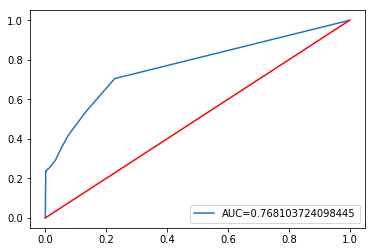

In [64]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc,roc_curve

rf = RandomForestClassifier(n_estimators=10,
                            random_state=1,
                            class_weight='balanced')

rf.fit(train_features,train_target)
predictions = rf.predict(test_features)
probalities = rf.predict_proba(test_features)

accuracy = predictions == test_target

true_positives = (predictions==1) & (test_target==1)
false_positives = (predictions==1) & (test_target==0)
true_negatives = (predictions==0) & (test_target==0)
false_negatives = (predictions==0) & (test_target==1)

sensitivity = np.sum(true_positives) / (np.sum(true_positives)+np.sum(false_negatives))

specificity = np.sum(true_negatives) / (np.sum(true_negatives) + np.sum(false_positives))

print('Sensibility of predictions is about : {}'.format(sensitivity))
print('Specificity of predictions is about : {}'.format(specificity))

fprs, tprs, thresholds = roc_curve(test_target, probalities[:,1], pos_label=1)
aucs = auc(fprs,tprs)

print('Perimeter of AUC curb : {}'.format(aucs))

plt.plot(fprs,tprs,label='AUC={}'.format(aucs))
plt.plot([0,1],[0,1],color='red')
plt.legend(loc='lower right')
plt.show()



#### The reults are better so we can attempt a first move with this model... 

## 5 - Results and operation

#### In production, an input of values of the features are sent to the model before the ingot been cut in the saw equipment. If the model predict a drift, an operation of preventive maintenance (change of diamant cutwire for example is then performed in order to prevent the drift or the anomaly. And the ingot is cut into wafers...

In [67]:

def prediction_maintenance(cumul_wafers,days_since_emptying,is_mono,days_of_emptying,WaferProduction):

    data = [cumul_wafers,
            days_since_emptying,
            is_mono,
            days_of_emptying,
            WaferProduction]
    
    data_res = np.asarray(data).reshape(1,-1)
    
    #data = StandardScaler().fit_transform(data_res)
    data = data_res
    prevision = rf.predict(data)
    prevision_proba = rf.predict_proba(data)
    
    if prevision:
        print('With the data given in input, we can predict that a maintenance action is necesary !!!')
    else :
        print('With the data given in input, no need at the moment for a maintenance action...')
    
    print('Probalities of need of action maintenance {}%'.format(prevision_proba[:,1]*100))
    
    return prevision_proba

#
print('--'*20)
### day 1
cumul_wafers = 10
days_since_emptying = 1
is_mono = 0
days_of_emptying= 0
WaferProduction= 0

prediction = prediction_maintenance(cumul_wafers,days_since_emptying,is_mono,days_of_emptying,WaferProduction)
print('--'*20)

### day 24
cumul_wafers = 879000
days_since_emptying = 24
is_mono = 1
days_of_emptying= 0
WaferProduction= 8790000

prediction = prediction_maintenance(cumul_wafers,days_since_emptying,is_mono,days_of_emptying,WaferProduction)
print('--'*20)


----------------------------------------
With the data given in input, we can predict that a maintenance action is necesary !!!
Probalities of need of action maintenance [ 70.]%
----------------------------------------
With the data given in input, no need at the moment for a maintenance action...
Probalities of need of action maintenance [ 30.]%
----------------------------------------


#### The model is perfectibe but it gives some interesting results. For example, the ratio of non quality on wafers cut dropped at 5% when it culminates at 15% before the predictive model. 

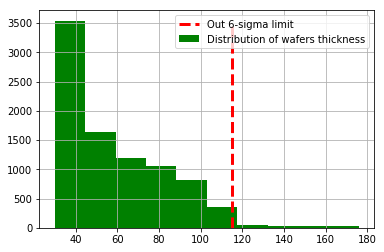

In [69]:
data_maintenance.TTV.hist(label="Distribution of wafers thickness",color="green")
plt.plot([115, 115], [0, 3500],
         color='red',
         linestyle='--',
         linewidth=3,
         label="Out 6-sigma limit")

plt.legend(loc='upper right');
plt.show()

#### Then, this project was a good example of a smart use of data science for accurate prediction of action maintenance... A first step towards industry 4.0 for solar manufacturing !!!

<img src="./Pictures/Fotolia_83701344_XS.jpg" />
